# Simulation d'un Trou Noir Optique (Schwarzschild)

Ce notebook implémente une simulation FDFD (Finite-Difference Frequency-Domain) d'un analogue optique de trou noir de Schwarzschild.

## 1. Importation des bibliothèques

In [ ]:
import ceviche
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from ceviche import fdfd_ez

ModuleNotFoundError: No module named 'ceviche.fdfd_ez'

## 2. Définition des paramètres physiques

### Paramètres du trou noir (en micromètres, μm)

In [ ]:
M = 2.5         # Masse M en μm (R_s = 2M = 5μm) [cite: 201, 599]
R_s = 2 * M     # Rayon de Schwarzschild (horizon) = 5.0 μm [cite: 201]
R_0 = 6 * M     # Rayon extérieur de l'analogue = 15.0 μm [cite: 203]

print(f"Rayon de Schwarzschild (R_s): {R_s} μm")
print(f"Rayon extérieur (R_0): {R_0} μm")

Rayon de Schwarzschild (R_s): 5.0 μm
Rayon extérieur (R_0): 15.0 μm


### Paramètres de la simulation

In [ ]:
wl = 0.5
omega = 2 * np.pi / wl
b_inf = 2.0
B_0 = b_inf * M

print(f"Longueur d'onde: {wl} μm")
print(f"Paramètre d'impact: {b_inf}")
print(f"B_0: {B_0} μm")

Longueur d'onde: 0.5 μm
Paramètre d'impact: 2.0
B_0: 5.0 μm


### Paramètres de la grille de simulation

In [ ]:
dl = 0.05
Nx, Ny = 600, 600
NPML = [20, 20]

print(f"Taille de la grille: {Nx} x {Ny}")
print(f"Taille physique: {Nx*dl} x {Ny*dl} μm")
print(f"Résolution: {dl} μm/pixel")

Taille de la grille: 600 x 600
Taille physique: 30.0 x 30.0 μm
Résolution: 0.05 μm/pixel


## 3. Fonction de l'indice de réfraction (Eq. 14)

In [ ]:
def get_n_schwarzschild(R_dim, b_inf_val):
    """
    Calcule l'indice de réfraction n(R) pour l'analogue de Schwarzschild.
    Basé sur l'Eq. 14, normalisé pour que n(R_0) = 1.
    """
    P = R_dim / M
    P_0 = R_0 / M
    P = np.maximum(P, 1e-6)
    C = 1.0 / np.sqrt(b_inf_val**-2 + 2 * P_0**-3)
    n = C * np.sqrt(b_inf_val**-2 + 2 * P**-3)
    return n

## 4. Construction de la permittivité de l'analogue

In [ ]:
print("Construction de la géométrie de l'analogue...")

# Coordonnées de la grille (centrée sur (0,0))
x_coords = (np.arange(Nx) - Nx/2) * dl
y_coords = (np.arange(Ny) - Ny/2) * dl
X, Y = np.meshgrid(x_coords, y_coords)
R_dim = np.sqrt(X**2 + Y**2)

# Initialise la permittivité avec np.complex128 pour une meilleure précision
epsilon_r = np.ones((Nx, Ny), dtype=np.complex128)

Construction de la géométrie de l'analogue...


### Création des 16 anneaux concentriques

In [ ]:
# Création des 16 anneaux concentriques 
N_annuli = 16
w = (R_0 - R_s) / (N_annuli - 1)
w_half = w / 2.0

# Définition des bords des anneaux
r_edges = np.zeros(N_annuli + 1)
r_edges[0] = R_s
r_edges[1] = R_s + w_half
r_edges[N_annuli] = R_0
r_edges[N_annuli - 1] = R_0 - w_half
for i in range(2, N_annuli - 1):
    r_edges[i] = r_edges[1] + (i - 1) * w

# Calcul de l'indice au centre de chaque anneau
r_centers = (r_edges[:-1] + r_edges[1:]) / 2
n_values = get_n_schwarzschild(r_centers, b_inf)

# Remplissage de la grille epsilon_r avec les valeurs des anneaux
for i in range(N_annuli):
    mask = (R_dim > r_edges[i]) & (R_dim <= r_edges[i+1])
    epsilon_r[mask] = n_values[i]**2

# CORRECTION 1 : Absorbeur central avec +1j (perte)
mask_absorber = (R_dim <= R_s)
epsilon_r[mask_absorber] = n_values[0]**2 + 1j * np.pi

print(f"Nombre d'anneaux: {N_annuli}")
print(f"Largeur d'anneau: {w:.3f} μm")

Nombre d'anneaux: 16
Largeur d'anneau: 0.667 μm


## 5. Définition de la source (Faisceau Gaussien)

In [ ]:
# CORRECTION 2 : Ajout des guides d'ondes absorbants
# L'article mentionne une largeur totale de faisceau de 2 lambda 
beam_width_pixels = (2 * wl) / dl
guide_left_idx = int(x_center_idx - beam_width_pixels / 2)
guide_right_idx = int(x_center_idx + beam_width_pixels / 2)

# Y_mask pour appliquer les guides jusqu'au bord de l'analogue (R_0)
y_center_idx = Ny // 2
R_0_pixels = R_0 / dl
y_end_idx = int(y_center_idx - R_0_pixels) # Bord inférieur de l'analogue

# Créer les murs absorbants
waveguide_mask_left = np.zeros((Nx, Ny), dtype=bool)
waveguide_mask_right = np.zeros((Nx, Ny), dtype=bool)

# Murs de la source jusqu'à l'analogue
waveguide_mask_left[y_launch_idx:y_end_idx, :guide_left_idx] = True
waveguide_mask_right[y_launch_idx:y_end_idx, guide_right_idx:] = True

# Appliquer l'absorption (encore +1j pour la perte)
epsilon_r[waveguide_mask_left] += 1j * np.pi
epsilon_r[waveguide_mask_right] += 1j * np.pi

print(f"Guides d'ondes ajoutés de x={guide_left_idx} à x={guide_right_idx}")

In [ ]:
# Faisceau lancé depuis le bas, centré sur x = B_0
source = np.zeros((Nx, Ny), dtype=np.complex128)
y_launch_idx = NPML[0] + 10
x_center_idx = Nx/2 + B_0 / dl
delta_pixels = (wl / 2) / dl
x_indices = np.arange(Nx)

gaussian = np.exp(-(x_indices - x_center_idx)**2 / (2 * delta_pixels**2))
source[y_launch_idx, :] = gaussian

print(f"Source placée à y_idx = {y_launch_idx}, x_center_idx = {x_center_idx:.1f}")
print(f"Largeur du faisceau: {delta_pixels:.2f} pixels")

Source placée à y_idx = 30, x_center_idx = 400.0
Largeur du faisceau: 5.00 pixels


### Ajout des guides d'ondes absorbants

## 6. Lancement de la simulation FDFD

In [ ]:
print("Lancement de la simulation FDFD (cela peut prendre un moment)...")
# Initialise le solveur FDFD
fdfd = fdfd_ez(omega, dl, epsilon_r, NPML)

# Résout les équations de Maxwell pour le champ Ez
Ex, Ey, Ez = fdfd.solve(source)

print("Simulation terminée.")

Lancement de la simulation FDFD (cela peut prendre un moment)...
Simulation terminée.


## 7. Visualisation des résultats

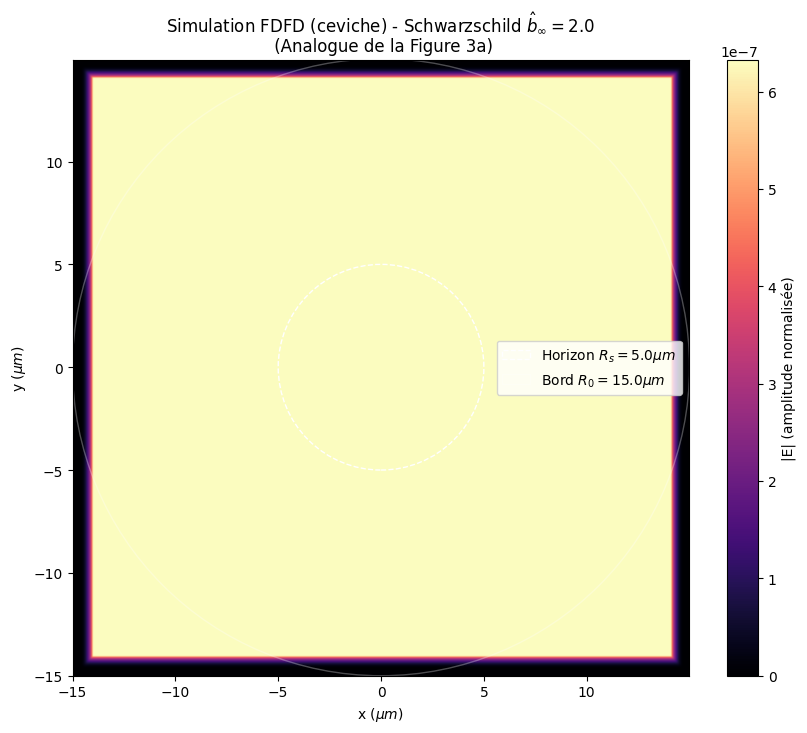

In [ ]:
# Amplitude du champ électrique
E_amp = np.abs(Ez)

# Ignorer les PMLs pour une meilleure échelle de couleur
E_amp_plot = E_amp[NPML[0]:-NPML[0], NPML[1]:-NPML[1]]

# Gérer le cas où la simulation échoue (pour éviter les erreurs)
vmax_val = np.max(E_amp_plot)
if vmax_val == 0 or not np.isfinite(vmax_val):
    vmax_val = 1.0
    print("Avertissement : L'amplitude max est nulle ou infinie.")

# Définition des limites pour le tracé (en μm)
extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]

fig, ax = plt.subplots(figsize=(10, 8))
# Clipper le vmax pour mieux voir (comme dans la Fig. 3)
im = ax.imshow(E_amp.T, cmap='magma', origin='lower', extent=extent,
                vmax=vmax_val * 0.5, vmin=0)

# Ajout des cercles pour R_s (horizon) et R_0 (bord de l'analogue)
circle_rs = Circle((0, 0), R_s, fill=False, color='w', linestyle='--', label=f'Horizon $R_s = {R_s:.1f} \mu m$')
circle_r0 = Circle((0, 0), R_0, fill=False, color='w', linestyle='-', alpha=0.3, label=f'Bord $R_0 = {R_0:.1f} \mu m$')
ax.add_patch(circle_rs)
ax.add_patch(circle_r0)

# Étiquettes et titre
ax.set_xlabel("x ($\mu m$)")
ax.set_ylabel("y ($\mu m$)")
ax.set_title(f"Simulation FDFD (ceviche) - Schwarzschild $\hat{{b}}_{{\infty}} = {b_inf}$ \n (Analogue de la Figure 3a)")
ax.legend()
plt.colorbar(im, label="|E| (amplitude normalisée)")
ax.set_aspect('equal')

# Zoomer sur la zone d'intérêt (enlever les PMLs)
ax.set_xlim(-R_0, R_0)
ax.set_ylim(-R_0, R_0 + 2*dl*NPML[0])

plt.show()